In [6]:
# buil-in
import datetime

# 3rd party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# custom
from gpw_data import GPWData

plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

In [26]:
# strategy 1 tests

data = GPWData()
etfw20l = data.load(symbols='ETFW20L')

# params
time_window = 8 #3  # 8/9 daje najlepsze jak na razie
"""
przy time window 3-7 jest strata
przy 8-9 lepiej niz b&h
przy >=10 gorzej niz b&h

ale to tylko dla etf-WIG20. dla s&p i dex jest totalnie gorzej...
"""
# long_threshold = 35
# short_threshold = 25
long_threshold = 35
short_threshold = 30
"""
"""

# calculate signals
for price in ('high', 'low', 'close'):
    etfw20l.loc[:, 'ema_{}_{}'.format(time_window, price)] = etfw20l[price].ewm(span=time_window, adjust=False).mean()
# calculate ADR = EMA_H - EMA_L
etfw20l.loc[:, 'adr'] = etfw20l['ema_{}_high'.format(time_window)] - etfw20l['ema_{}_low'.format(time_window)]
# calculate perc = ((EMA_H - EMA_C)*100)/ADR
etfw20l.loc[:, 'perc_range'] = ((etfw20l['ema_{}_high'.format(time_window)]-etfw20l['ema_{}_close'.format(time_window)])*100)/etfw20l['adr']

for signal_type in ('long', 'short'):
    if signal_type == 'long':
        etfw20l.loc[:, 'potential_signal'] = np.where(etfw20l['perc_range'] > long_threshold, 1, 0)
    elif signal_type == 'short':
        etfw20l.loc[:, 'potential_signal'] = np.where(etfw20l['perc_range'] < short_threshold, 1, 0)
    etfw20l.loc[:, 'previous_potential_signal'] = etfw20l['potential_signal'].shift(1)
    etfw20l['previous_potential_signal'].fillna(value=0, inplace=True)
    etfw20l.loc[:, 'entry_{}'.format(signal_type)] = np.where(
        (etfw20l['potential_signal']==1) & (etfw20l['previous_potential_signal']==0), 1, 0
    )
    etfw20l.loc[:, 'exit_{}'.format(signal_type)] = np.where(
        (etfw20l['potential_signal']==0) & (etfw20l['previous_potential_signal']==1), 1, 0
    )
    etfw20l.drop(['potential_signal', 'previous_potential_signal'], axis=1, inplace=True)

print(etfw20l.head(15))

              open    high     low   close  volume  ema_8_high   ema_8_low  \
date                                                                         
2010-09-28  262.40  263.30  261.40  261.40    1334  263.300000  261.400000   
2010-09-29  262.90  264.50  262.40  262.50    1194  263.566667  261.622222   
2010-09-30  262.17  265.15  261.47  265.15    3802  263.918519  261.588395   
2010-10-01  264.16  265.50  264.00  264.80    5170  264.269959  262.124307   
2010-10-04  268.00  268.00  263.00  266.43   14490  265.098857  262.318906   
2010-10-05  266.58  275.00  265.82  275.00   15134  267.299111  263.096927   
2010-10-06  272.31  273.20  269.80  270.50    2294  268.610420  264.586498   
2010-10-07  270.70  271.30  267.00  267.00    4315  269.208104  265.122832   
2010-10-08  267.90  268.60  265.40  265.40     464  269.072970  265.184425   
2010-10-11  265.87  267.40  265.83  266.70     949  268.701199  265.327886   
2010-10-12  264.90  267.20  264.00  265.98    1151  268.367599  

In [27]:
# gather entry/exist signals to visualize data
idxs_entry_long = etfw20l.index[etfw20l['entry_long'] == 1].tolist()
idxs_exit_long = etfw20l.index[etfw20l['exit_long'] == 1].tolist()
if len(idxs_entry_long) > len(idxs_exit_long):
    idxs_entry_long = idxs_entry_long[:-1]
elif len(idxs_exit_long) > len(idxs_entry_long):
    idxs_exit_long = idxs_exit_long[:-1]
elif len(idxs_entry_long) != len(idxs_exit_long):
    # logically they can differ only by 1, so if its not the case sth is wrong
    raise ValueError
long_periods = list(zip(idxs_entry_long, idxs_exit_long))

# same for short periods
idxs_entry_short = etfw20l.index[etfw20l['entry_short'] == 1].tolist()
idxs_exit_short = etfw20l.index[etfw20l['exit_short'] == 1].tolist()
if len(idxs_entry_short) > len(idxs_exit_short):
    idxs_entry_short = idxs_entry_short[:-1]
elif len(idxs_exit_short) > len(idxs_entry_short):
    idxs_exit_short = idxs_exit_short[:-1]
elif len(idxs_entry_short) != len(idxs_exit_short):
    # logically they can differ only by 1, so if its not the case sth is wrong
    raise ValueError
short_periods = list(zip(idxs_entry_short, idxs_exit_short))

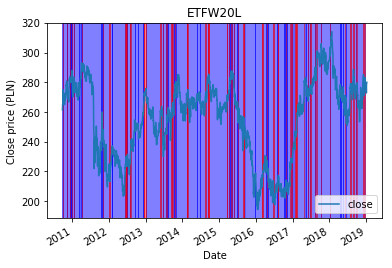

In [28]:
ax = etfw20l.plot(y='close')
plt.title('ETFW20L')
plt.xlabel('Date')
plt.ylabel('Close price (PLN)')

# add vertical spacing to depict holding periods
for lp in long_periods:
    ax.axvspan(lp[0], lp[1], alpha=0.5, color='blue')
for sp in short_periods:
    ax.axvspan(sp[0], sp[1], alpha=0.5, color='red')


In [29]:
# how many winning and loosing trades there is without transaction costs?
winning_trades = 0
loosing_trades = 0
for lp in long_periods:
    if etfw20l.loc[lp[1], 'close'] - etfw20l.loc[lp[0], 'close'] > 0:
        winning_trades += 1
    else:
        loosing_trades += 1
for sp in short_periods:
    if etfw20l.loc[sp[0], 'close'] - etfw20l.loc[sp[1], 'close'] > 0:
        winning_trades += 1
    else:
        loosing_trades += 1
        
print('Winning: ', winning_trades)
print('Loosing: ', loosing_trades)
# > 60% win-rate without transaction costs

Winning:  126
Loosing:  44


In [30]:
#### strategy backtest

# strategy setup
fee_perc=0.0038
min_fee_perc=4

def calculate_fee(shares_count=None, price=None):
    transaction_value = shares_count * price
    fee = transaction_value * fee_perc
    if fee < min_fee_perc:
        fee = min_fee_perc
    return round(fee, 2)

In [39]:
def optimize(symbol=None, time_window=3, long_threshold=35, short_threshold=30):
    """
    strategy params: time_window, long_threshold, short_threshold
    """
    data = GPWData()
    etf_full = data.load(symbols=symbol)
    
    # split data into optimize/validate
    length = len(etf_full.index)
    etf_t = etf_full.iloc[:length//2, :].copy()
    etf_v = etf_full.iloc[length//2:, :].copy()
    
    # calculate signals
    for etf in (etf_t, etf_v):
        for price in ('high', 'low', 'close'):
            etf.loc[:, 'ema_{}_{}'.format(time_window, price)] = etf[price].ewm(span=time_window, adjust=False).mean()
        etf.loc[:, 'adr'] = etf['ema_{}_high'.format(time_window)] - etf['ema_{}_low'.format(time_window)]
        etf.loc[:, 'perc_range'] = \
            ((etf['ema_{}_high'.format(time_window)]-etf['ema_{}_close'.format(time_window)])*100)/etf['adr']
        
        for signal_type in ('long', 'short'):
            if signal_type == 'long':
                etf.loc[:, 'potential_signal'] = np.where(etf['perc_range'] > long_threshold, 1, 0)
            elif signal_type == 'short':
                etf.loc[:, 'potential_signal'] = np.where(etf['perc_range'] < short_threshold, 1, 0)
            etf.loc[:, 'previous_potential_signal'] = etf['potential_signal'].shift(1)
            etf['previous_potential_signal'].fillna(value=0, inplace=True)
            etf.loc[:, 'entry_{}'.format(signal_type)] = np.where(
                (etf['potential_signal']==1) & (etf['previous_potential_signal']==0), 1, 0
            )
            etf.loc[:, 'exit_{}'.format(signal_type)] = np.where(
                (etf['potential_signal']==0) & (etf['previous_potential_signal']==1), 1, 0
            )
            etf.drop(['potential_signal', 'previous_potential_signal'], axis=1, inplace=True)
            
    
    for etf in (etf_t, etf_v):
        # run backtest
        initial_investment = 10000
        available_money = 0
        available_money += initial_investment #  10k PLN
        shares_count = 0
        account_value = 0

        etf.loc[:, 'shares_count'] = 0
        etf.loc[:, 'daily_returns'] = 0
        etf.loc[:, 'rate_of_return'] = 0
        etf.loc[:, 'account_value'] = 0
        etf.loc[:, 'NAV'] = 0
        etf.loc[:, 'b_and_h_ror'] = 0  # buy&hold rate of return
        etf.loc[:, 'b_and_h_nav'] = 0
        
        # run tested strategy
        for idx, row in etf.iterrows():
            print('processing date: ', idx)
            
            if row['exit_long'] == 1:
                fee = calculate_fee(shares_count=abs(shares_count), price=row['close'])
                available_money += (shares_count*row['close'])-fee
                shares_count = 0
                account_value = 0
                
                print('fee: ', fee)
                print('sell price is: ', row['close'])
                print('available money after exit: ', available_money)
                
            if row['exit_short'] == 1:
                fee = calculate_fee(shares_count=abs(shares_count), price=row['close'])
                available_money -= (-shares_count*row['close'])+fee
                shares_count = 0
                account_value = 0
                
                print('fee: ', fee)
                print('sell price is: ', row['close'])
                print('available money after exit: ', available_money)
                
            if row['entry_long'] == 1:
                shares_count = available_money // (row['close'] + (row['close']*fee_perc))
                fee = calculate_fee(shares_count=abs(shares_count), price=row['close'])
                account_value = shares_count*row['close']
                available_money -= account_value+fee
                
                print('buy price is: ', row['close'])
                print('shares count: ', shares_count)
                print('fee: ', fee)
                print('available money after entry long: ', available_money)

            if row['entry_short'] == 1:
                shares_count = -1 * (available_money // (row['close'] + (row['close']*fee_perc)))
                fee = calculate_fee(shares_count=abs(shares_count), price=row['close'])
                account_value = shares_count*row['close'] # that is negative
                available_money += (-1*account_value)-fee
                
                print('buy price is: ', row['close'])
                print('shares count: ', shares_count)
                print('fee: ', fee)
                print('available money after short: ', available_money)
                
            if (row['entry_long'] == 0)&(row['exit_long'] == 0)&(row['entry_short'] == 0)&(row['exit_short'] == 0):
                account_value = shares_count*row['close']
            
            etf.loc[idx, 'shares_count'] = shares_count
            etf.loc[idx, 'account_value'] = account_value
            
            nav = account_value+available_money
            etf.loc[idx, 'NAV'] = nav

            rate_of_return = ((nav-initial_investment)/initial_investment)*100
            etf.loc[idx, 'rate_of_return'] = rate_of_return
            
        # run buy&hold benchmark
        counter = 0
        for idx, row in etf.iterrows():
            if counter == 0:
                _shares_count = initial_investment // (row['close'] + (row['close']*fee_perc))
                _fee = calculate_fee(shares_count=_shares_count, price=row['close'])
                _account_value = _shares_count*row['close']
                _initial_investment = initial_investment - _fee
                _available_money = initial_investment - _fee - _account_value  # left from the first purchease
                _rate_of_return = ((_account_value-_initial_investment)/_initial_investment)*100
                etf.loc[idx, 'b_and_h_ror'] = _rate_of_return
            _account_value = _shares_count*row['close']
            _nav = _account_value+_available_money
            etf.loc[idx, 'b_and_h_ror'] = ((_nav-_initial_investment)/_initial_investment)*100
            etf.loc[idx, 'b_and_h_nav'] = _nav
            # print('buy and hold theoretical nav... ', _account_value)
            counter += 1
            
    # calculate rerurns
    # To find the return R(t1,t2) between dates t1 and t2 one takes  R(t1,t2)=NAV(t2)/NAV(t1)−1
    for etf in (etf_t, etf_v):
        etf.loc[:,'NAV_prev'] = etf['NAV'].shift(1)
        etf.loc[:,'daily_returns'] = etf['NAV']/etf.loc[:,'NAV_prev']-1
        
        etf.loc[:,'b_and_h_nav_prev'] = etf['b_and_h_nav'].shift(1)
        # etf.loc[:,'b_and_h_daily_returns'] = etf.loc[:,'b_and_h_nav_prev']/etf['b_and_h_nav']-1
        etf.loc[:,'b_and_h_daily_returns'] = etf['b_and_h_nav']/etf.loc[:,'b_and_h_nav_prev']-1

    return etf_t, etf_v
            
etf_t, etf_v = optimize(symbol='ETFW20L')

processing date:  2010-09-28 00:00:00
buy price is:  261.4
shares count:  38.0
fee:  37.75
available money after entry long:  29.05000000000109
processing date:  2010-09-29 00:00:00
processing date:  2010-09-30 00:00:00
fee:  38.29
sell price is:  265.15
available money after exit:  10066.46
processing date:  2010-10-01 00:00:00
buy price is:  264.8
shares count:  37.0
fee:  37.23
available money after entry long:  231.6299999999992
processing date:  2010-10-04 00:00:00
fee:  37.46
sell price is:  266.43
available money after exit:  10052.08
processing date:  2010-10-05 00:00:00
buy price is:  275.0
shares count:  -36.0
fee:  37.62
available money after short:  19914.46
processing date:  2010-10-06 00:00:00
fee:  37.0
sell price is:  270.5
available money after exit:  10139.46
processing date:  2010-10-07 00:00:00
buy price is:  267.0
shares count:  37.0
fee:  37.54
available money after entry long:  222.91999999999825
processing date:  2010-10-08 00:00:00
processing date:  2010-10-11 

processing date:  2011-03-03 00:00:00
fee:  35.74
sell price is:  276.66
available money after exit:  9612.900000000001
buy price is:  276.66
shares count:  -34.0
fee:  35.74
available money after short:  18983.600000000002
processing date:  2011-03-04 00:00:00
fee:  35.92
sell price is:  278.0
available money after exit:  9495.680000000002
buy price is:  278.0
shares count:  34.0
fee:  35.92
available money after entry long:  7.760000000002037
processing date:  2011-03-07 00:00:00
processing date:  2011-03-08 00:00:00
processing date:  2011-03-09 00:00:00
processing date:  2011-03-10 00:00:00
processing date:  2011-03-11 00:00:00
processing date:  2011-03-14 00:00:00
fee:  35.76
sell price is:  276.81
available money after exit:  9383.540000000003
buy price is:  276.81
shares count:  -33.0
fee:  34.71
available money after short:  18483.560000000005
processing date:  2011-03-15 00:00:00
processing date:  2011-03-16 00:00:00
fee:  33.96
sell price is:  270.83
available money after exit

available money after exit:  9020.110000000011
buy price is:  277.9
shares count:  -32.0
fee:  33.79
available money after short:  17879.12000000001
processing date:  2011-07-22 00:00:00
processing date:  2011-07-25 00:00:00
fee:  33.79
sell price is:  277.9
available money after exit:  8952.53000000001
buy price is:  277.9
shares count:  32.0
fee:  33.79
available money after entry long:  25.940000000009604
processing date:  2011-07-26 00:00:00
processing date:  2011-07-27 00:00:00
processing date:  2011-07-28 00:00:00
fee:  33.67
sell price is:  276.9
available money after exit:  8853.070000000009
processing date:  2011-07-29 00:00:00
buy price is:  277.4
shares count:  -31.0
fee:  32.68
available money after short:  17419.790000000008
processing date:  2011-08-01 00:00:00
fee:  32.35
sell price is:  274.59
available money after exit:  8875.150000000009
buy price is:  274.59
shares count:  32.0
fee:  33.39
available money after entry long:  54.880000000010114
processing date:  2011-0

processing date:  2012-06-01 00:00:00
processing date:  2012-06-04 00:00:00
processing date:  2012-06-05 00:00:00
processing date:  2012-06-06 00:00:00
processing date:  2012-06-08 00:00:00
fee:  29.54
sell price is:  215.9
available money after exit:  7801.410000000011
buy price is:  215.9
shares count:  -35.0
fee:  28.71
available money after short:  15329.200000000012
processing date:  2012-06-11 00:00:00
processing date:  2012-06-12 00:00:00
processing date:  2012-06-13 00:00:00
processing date:  2012-06-14 00:00:00
fee:  29.53
sell price is:  222.0
available money after exit:  7529.670000000012
processing date:  2012-06-15 00:00:00
buy price is:  224.96
shares count:  -33.0
fee:  28.21
available money after short:  14925.140000000012
processing date:  2012-06-18 00:00:00
fee:  28.14
sell price is:  224.39
available money after exit:  7492.130000000012
buy price is:  224.39
shares count:  33.0
fee:  28.14
available money after entry long:  59.120000000011714
processing date:  2012-

processing date:  2012-10-25 00:00:00
processing date:  2012-10-26 00:00:00
fee:  26.84
sell price is:  243.6
available money after exit:  7039.04000000001
buy price is:  243.6
shares count:  -28.0
fee:  25.92
available money after short:  13833.92000000001
processing date:  2012-10-29 00:00:00
fee:  25.91
sell price is:  243.5
available money after exit:  6990.010000000009
buy price is:  243.5
shares count:  28.0
fee:  25.91
available money after entry long:  146.10000000000946
processing date:  2012-10-30 00:00:00
processing date:  2012-10-31 00:00:00
processing date:  2012-11-02 00:00:00
processing date:  2012-11-05 00:00:00
processing date:  2012-11-06 00:00:00
processing date:  2012-11-07 00:00:00
processing date:  2012-11-08 00:00:00
processing date:  2012-11-09 00:00:00
processing date:  2012-11-12 00:00:00
processing date:  2012-11-13 00:00:00
fee:  26.23
sell price is:  246.5
available money after exit:  7021.87000000001
processing date:  2012-11-14 00:00:00
buy price is:  249

processing date:  2013-08-27 00:00:00
processing date:  2013-08-28 00:00:00
processing date:  2013-08-29 00:00:00
fee:  19.38
sell price is:  255.0
available money after exit:  5236.5900000000065
buy price is:  255.0
shares count:  -20.0
fee:  19.38
available money after short:  10317.210000000006
processing date:  2013-08-30 00:00:00
processing date:  2013-09-02 00:00:00
fee:  19.64
sell price is:  258.47
available money after exit:  5128.1700000000055
processing date:  2013-09-03 00:00:00
buy price is:  256.0
shares count:  19.0
fee:  18.48
available money after entry long:  245.69000000000597
processing date:  2013-09-04 00:00:00
processing date:  2013-09-05 00:00:00
processing date:  2013-09-06 00:00:00
processing date:  2013-09-09 00:00:00
processing date:  2013-09-10 00:00:00
fee:  18.34
sell price is:  253.95
available money after exit:  5052.400000000006
buy price is:  253.95
shares count:  -19.0
fee:  18.34
available money after short:  9859.110000000006
processing date:  2013

processing date:  2014-01-31 00:00:00
processing date:  2014-02-03 00:00:00
processing date:  2014-02-04 00:00:00
fee:  15.75
sell price is:  259.0
available money after exit:  4183.6900000000105
buy price is:  259.0
shares count:  -16.0
fee:  15.75
available money after short:  8311.94000000001
processing date:  2014-02-05 00:00:00
fee:  15.75
sell price is:  259.0
available money after exit:  4152.19000000001
buy price is:  259.0
shares count:  15.0
fee:  14.76
available money after entry long:  252.4300000000094
processing date:  2014-02-06 00:00:00
fee:  15.05
sell price is:  264.06
available money after exit:  4198.28000000001
buy price is:  264.06
shares count:  -15.0
fee:  15.05
available money after short:  8144.13000000001
processing date:  2014-02-07 00:00:00
processing date:  2014-02-10 00:00:00
fee:  15.08
sell price is:  264.6
available money after exit:  4160.05000000001
buy price is:  264.6
shares count:  15.0
fee:  15.08
available money after entry long:  175.9700000000

processing date:  2014-06-20 00:00:00
processing date:  2014-06-23 00:00:00
processing date:  2014-06-24 00:00:00
fee:  15.52
sell price is:  272.34
available money after exit:  4291.650000000008
buy price is:  272.34
shares count:  15.0
fee:  15.52
available money after entry long:  191.03000000000793
processing date:  2014-06-25 00:00:00
fee:  15.47
sell price is:  271.37
available money after exit:  4246.110000000008
buy price is:  271.37
shares count:  -15.0
fee:  15.47
available money after short:  8301.190000000008
processing date:  2014-06-26 00:00:00
fee:  15.16
sell price is:  266.0
available money after exit:  4296.030000000008
buy price is:  266.0
shares count:  16.0
fee:  16.17
available money after entry long:  23.860000000007858
processing date:  2014-06-27 00:00:00
fee:  16.37
sell price is:  269.2
available money after exit:  4314.690000000008
processing date:  2014-06-30 00:00:00
buy price is:  266.0
shares count:  16.0
fee:  16.17
available money after entry long:  42

processing date:  2014-11-17 00:00:00
buy price is:  271.6
shares count:  36.0
fee:  37.15
available money after entry long:  185.25
processing date:  2014-11-18 00:00:00
processing date:  2014-11-19 00:00:00
processing date:  2014-11-20 00:00:00
fee:  37.59
sell price is:  274.8
available money after exit:  10040.460000000001
buy price is:  274.8
shares count:  -36.0
fee:  37.59
available money after short:  19895.670000000002
processing date:  2014-11-21 00:00:00
fee:  37.35
sell price is:  273.0
available money after exit:  10030.320000000002
processing date:  2014-11-24 00:00:00
buy price is:  271.0
shares count:  36.0
fee:  37.07
available money after entry long:  237.25000000000182
processing date:  2014-11-25 00:00:00
processing date:  2014-11-26 00:00:00
processing date:  2014-11-27 00:00:00
processing date:  2014-11-28 00:00:00
fee:  37.61
sell price is:  274.9
available money after exit:  10096.04
processing date:  2014-12-01 00:00:00
buy price is:  271.41
shares count:  37.0

processing date:  2015-04-24 00:00:00
fee:  34.32
sell price is:  282.2
available money after exit:  9122.980000000001
buy price is:  282.2
shares count:  32.0
fee:  34.32
available money after entry long:  58.26000000000204
processing date:  2015-04-27 00:00:00
fee:  34.94
sell price is:  287.3
available money after exit:  9216.920000000002
buy price is:  287.3
shares count:  -31.0
fee:  33.84
available money after short:  18089.380000000005
processing date:  2015-04-28 00:00:00
fee:  33.63
sell price is:  285.51
available money after exit:  9204.940000000006
buy price is:  285.51
shares count:  32.0
fee:  34.72
available money after entry long:  33.90000000000691
processing date:  2015-04-29 00:00:00
processing date:  2015-04-30 00:00:00
processing date:  2015-05-04 00:00:00
processing date:  2015-05-05 00:00:00
processing date:  2015-05-06 00:00:00
fee:  34.55
sell price is:  284.09
available money after exit:  9090.230000000007
processing date:  2015-05-07 00:00:00
buy price is:  2

processing date:  2015-09-10 00:00:00
fee:  43.35
sell price is:  248.0
available money after exit:  11513.129999999996
buy price is:  248.0
shares count:  -46.0
fee:  43.35
available money after short:  22877.779999999995
processing date:  2015-09-11 00:00:00
fee:  43.53
sell price is:  249.0
available money after exit:  11380.249999999995
buy price is:  249.0
shares count:  45.0
fee:  42.58
available money after entry long:  132.66999999999462
processing date:  2015-09-14 00:00:00
processing date:  2015-09-15 00:00:00
processing date:  2015-09-16 00:00:00
processing date:  2015-09-17 00:00:00
processing date:  2015-09-18 00:00:00
processing date:  2015-09-21 00:00:00
processing date:  2015-09-22 00:00:00
processing date:  2015-09-23 00:00:00
processing date:  2015-09-24 00:00:00
processing date:  2015-09-25 00:00:00
processing date:  2015-09-28 00:00:00
processing date:  2015-09-29 00:00:00
processing date:  2015-09-30 00:00:00
processing date:  2015-10-01 00:00:00
processing date:  

processing date:  2016-07-20 00:00:00
processing date:  2016-07-21 00:00:00
fee:  37.49
sell price is:  209.92
available money after exit:  9960.09
buy price is:  209.92
shares count:  47.0
fee:  37.49
available money after entry long:  56.36000000000058
processing date:  2016-07-22 00:00:00
processing date:  2016-07-25 00:00:00
processing date:  2016-07-26 00:00:00
processing date:  2016-07-27 00:00:00
fee:  37.58
sell price is:  210.4
available money after exit:  9907.580000000002
buy price is:  210.4
shares count:  -46.0
fee:  36.78
available money after short:  19549.2
processing date:  2016-07-28 00:00:00
processing date:  2016-07-29 00:00:00
fee:  36.02
sell price is:  206.07
available money after exit:  10033.960000000001
buy price is:  206.07
shares count:  48.0
fee:  37.59
available money after entry long:  105.01000000000022
processing date:  2016-08-01 00:00:00
processing date:  2016-08-02 00:00:00
processing date:  2016-08-03 00:00:00
processing date:  2016-08-04 00:00:00
f

processing date:  2016-12-06 00:00:00
processing date:  2016-12-07 00:00:00
processing date:  2016-12-08 00:00:00
processing date:  2016-12-09 00:00:00
fee:  35.59
sell price is:  223.0
available money after exit:  8970.369999999999
buy price is:  223.0
shares count:  40.0
fee:  33.9
available money after entry long:  16.469999999999345
processing date:  2016-12-12 00:00:00
processing date:  2016-12-13 00:00:00
processing date:  2016-12-14 00:00:00
fee:  34.76
sell price is:  228.71
available money after exit:  9130.109999999999
buy price is:  228.71
shares count:  -39.0
fee:  33.89
available money after short:  18015.91
processing date:  2016-12-15 00:00:00
fee:  33.49
sell price is:  226.0
available money after exit:  9168.42
buy price is:  226.0
shares count:  40.0
fee:  34.35
available money after entry long:  94.06999999999971
processing date:  2016-12-16 00:00:00
fee:  34.6
sell price is:  227.64
available money after exit:  9165.069999999998
buy price is:  227.64
shares count:  

processing date:  2017-05-08 00:00:00
processing date:  2017-05-09 00:00:00
fee:  32.31
sell price is:  283.45
available money after exit:  8584.73999999999
buy price is:  283.45
shares count:  -30.0
fee:  32.31
available money after short:  17055.929999999993
processing date:  2017-05-10 00:00:00
fee:  32.09
sell price is:  281.45
available money after exit:  8580.339999999993
buy price is:  281.45
shares count:  30.0
fee:  32.09
available money after entry long:  104.74999999999272
processing date:  2017-05-11 00:00:00
processing date:  2017-05-12 00:00:00
processing date:  2017-05-15 00:00:00
processing date:  2017-05-16 00:00:00
processing date:  2017-05-17 00:00:00
processing date:  2017-05-18 00:00:00
processing date:  2017-05-19 00:00:00
fee:  31.35
sell price is:  275.0
available money after exit:  8323.399999999992
buy price is:  275.0
shares count:  -30.0
fee:  31.35
available money after short:  16542.049999999992
processing date:  2017-05-22 00:00:00
fee:  31.29
sell price 

processing date:  2017-10-04 00:00:00
processing date:  2017-10-05 00:00:00
processing date:  2017-10-06 00:00:00
processing date:  2017-10-09 00:00:00
fee:  30.63
sell price is:  298.5
available money after exit:  8153.209999999991
buy price is:  298.5
shares count:  -27.0
fee:  30.63
available money after short:  16182.07999999999
processing date:  2017-10-10 00:00:00
processing date:  2017-10-11 00:00:00
processing date:  2017-10-12 00:00:00
fee:  31.23
sell price is:  304.34
available money after exit:  7933.669999999993
buy price is:  304.34
shares count:  25.0
fee:  28.91
available money after entry long:  296.25999999999385
processing date:  2017-10-13 00:00:00
processing date:  2017-10-16 00:00:00
processing date:  2017-10-17 00:00:00
processing date:  2017-10-18 00:00:00
processing date:  2017-10-19 00:00:00
processing date:  2017-10-20 00:00:00
processing date:  2017-10-23 00:00:00
processing date:  2017-10-24 00:00:00
processing date:  2017-10-25 00:00:00
processing date:  2

processing date:  2018-08-14 00:00:00
processing date:  2018-08-16 00:00:00
processing date:  2018-08-17 00:00:00
processing date:  2018-08-20 00:00:00
processing date:  2018-08-21 00:00:00
fee:  21.83
sell price is:  273.55
available money after exit:  5781.5299999999925
processing date:  2018-08-22 00:00:00
buy price is:  276.4
shares count:  20.0
fee:  21.01
available money after entry long:  232.51999999999225
processing date:  2018-08-23 00:00:00
fee:  21.28
sell price is:  280.0
available money after exit:  5811.2399999999925
buy price is:  280.0
shares count:  -20.0
fee:  21.28
available money after short:  11389.959999999992
processing date:  2018-08-24 00:00:00
processing date:  2018-08-27 00:00:00
processing date:  2018-08-28 00:00:00
processing date:  2018-08-29 00:00:00
processing date:  2018-08-30 00:00:00
processing date:  2018-08-31 00:00:00
processing date:  2018-09-03 00:00:00
processing date:  2018-09-04 00:00:00
fee:  21.3
sell price is:  280.2
available money after 

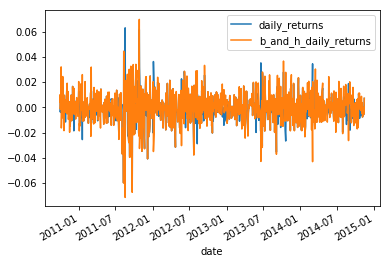

In [40]:
# etf_t.head(10)
t = etf_t.plot(y=['daily_returns','b_and_h_daily_returns'])

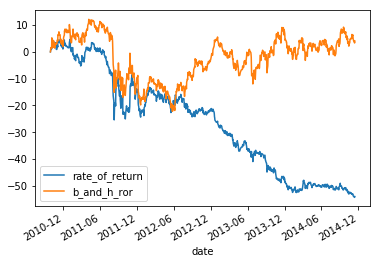

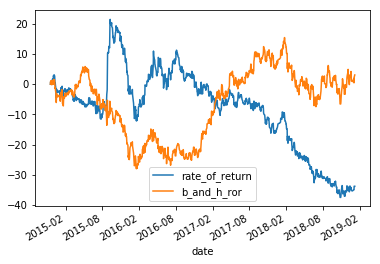

In [17]:
# just to check if graphs looks legit
ax3 = etf_t.plot(y=['rate_of_return', 'b_and_h_ror'])
ax4 = etf_v.plot(y=['rate_of_return', 'b_and_h_ror'])

In [41]:
def evaluate(df, returns_col, rate_of_returns_col):
    """
    Old version
    
    Excess daily returns assuming risk-free rate of 2% per annum and 252 trading days in a year
    
    Function outputs (or rather was outputing in previous verios)
        - Annualized Sharpe Ratio
        - Maximum Drowndown
        - Maximum Drowndown Duration
        - Expectation
        - Annualized Returns
        - No. of trades
    """
    # sharpe ratio
    excess_returns = df[returns_col] - 0.02/252
    mean_er = excess_returns.mean()
    std_dev_er = excess_returns.std()
    annualized_sharpe_ratio=(252**.5)*mean_er/std_dev_er
    # return annualized_sharpe_ratio
    print('annualized_sharpe_ratio: ', annualized_sharpe_ratio)

    # maximum draw down
    """
    high watermark can be done (there is some sort of function for such a operation)
    drowndown is easy - just substraction and then max
    maximum drawdown duration should also be some sort of rolling metric... note: its longet drown down, not 
    how long maximum drowndown lasted
    """
    cum_ret = np.array(df[rate_of_returns_col])
    cum_ret_lenght = len(cum_ret)
    
    highwatermark = np.zeros(cum_ret_lenght)
    drawdown = np.zeros(cum_ret_lenght)
    drawdownduration = np.zeros(cum_ret_lenght)
    for idx in range(1,cum_ret_lenght):
        highwatermark[idx] = max(
            highwatermark[idx-1], cum_ret[idx]
        )
        drawdown[idx] = highwatermark[idx] - cum_ret[idx]
        
        if drawdown[idx] == 0:
            drawdownduration[idx]=0
        else:
            drawdownduration[idx]=drawdownduration[idx-1]+1
            
    maximum_drawdown = max(drawdown)
    print('maximum_drawdown: ', maximum_drawdown)
    maximum_drawdown_duration = max(drawdownduration)
    print('maximum_drawdown_duration:', maximum_drawdown_duration)
    
    # still drowndowns but with vectorized pandas or numpy now...
    # you can use .cummax()

    
    
print('For strategy:')
evaluate(etf_t, 'daily_returns', 'rate_of_return')
print('\n')
print('For benchmark:')
evaluate(etf_t, 'b_and_h_daily_returns', 'b_and_h_ror')



For strategy:
annualized_sharpe_ratio:  -1.3726679703582245
maximum_drawdown:  64.2364999999999
maximum_drawdown_duration: 1001.0


For benchmark:
annualized_sharpe_ratio:  0.043053806662726256
maximum_drawdown:  34.253306231022115
maximum_drawdown_duration: 899.0


In [18]:
etf_t.head(5)

,open,high,low,close,volume,ema_3_high,ema_3_low,ema_3_close,adr,perc_range,...,shares_count,daily_returns,rate_of_return,account_value,NAV,b_and_h_ror,b_and_h_nav,NAV_prev,b_and_h_nav_prev,b_and_h_daily_returns
date,,,,,,,,,,,,,,,,,,,,,
2010-09-28,262.40,263.30,261.40,261.40,1334,263.30000,261.40000,261.4000,1.900,100.000000,...,38.0,NaN,-0.0400,9933.2,9996.00,0.000000,9962.25,NaN,NaN,NaN
2010-09-29,262.90,264.50,262.40,262.50,1194,263.90000,261.90000,261.9500,2.000,97.500000,...,38.0,0.004182,0.3780,9975.0,10037.80,0.419584,10004.05,9996.00,9962.25,0.004196
2010-09-30,262.17,265.15,261.47,265.15,3802,264.52500,261.68500,263.5500,2.840,34.330986,...,0.0,0.006217,1.0021,0.0,10100.21,1.430400,10104.75,10037.80,10004.05,0.010066
2010-10-01,264.16,265.50,264.00,264.80,5170,265.01250,262.84250,264.1750,2.170,38.594470,...,37.0,-0.000396,0.9621,9797.6,10096.21,1.296896,10091.45,10100.21,10104.75,-0.001316
2010-10-04,268.00,268.00,263.00,266.43,14490,266.50625,262.92125,265.3025,3.585,33.577406,...,0.0,0.002263,1.1906,0.0,10119.06,1.918643,10153.39,10096.21,10091.45,0.006138
